<a href="https://colab.research.google.com/github/lucascarter0/data-science-tools/blob/master/Covid19_Modeling_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting of COVID-19 Pandemic Using Markov-Chain Monte Carlo

The goal of this analysis is to create an epidemiological forecast of COVID-19 transmission using infectious disease models that have been fitted to COVID-19 test results. This analysis seeks to address the following questions:
- How well do early prediction models used to make quarantine policy recommendations reflect data that has since been measured?
- How well are quarantine measures slowing the spread of the virus?

A susceptible, infected, removed (SIR) model will be tuned to estimate performance characteristics of the virus using Markov Chain Monte Carlo (MCMC). 


In [0]:
# Importing needed libraries
!pip install pymc3==3.8
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd


# Data Collection

Data used for this analysis comes from the COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (https://github.com/CSSEGISandData/COVID-19). The repository contains time history and data summary entries at the global level and United States county level.

My initial goal was to create a model using US county data, but it appears that recovered cases have not been recorded. The code below combines daily reports from March 22nd to May 2nd and creates a single dataframe of confirmed, recovered, and active cases, as well as deaths.

In [144]:
from datetime import timedelta, date
import os

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

df = pd.DataFrame(columns=['Confirmed','Deaths','Recovered','Active'])
start_date = date(2020, 3, 22)
end_date = date(2020, 5, 2)
for single_date in daterange(start_date, end_date):
    date = single_date.strftime('%m-%d-%Y')
    basepath = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports'
    url = os.path.join(basepath, '{}.csv'.format(date))

    a = pd.read_csv(url, index_col=-1, usecols=['Confirmed','Deaths','Recovered','Active', 'Combined_Key'])

    try:
      df.loc[single_date] = a.loc['Dallas, Texas, US']
    except KeyError:
      continue

df.tail()

,Confirmed,Deaths,Recovered,Active
2020-04-27,3014,82,0,2932
2020-04-28,3240,94,0,3146
2020-04-29,3240,94,0,3146
2020-04-30,3531,104,0,3427
2020-05-01,3718,106,0,3612


### Nationwide Data Collection
Until it can be confirmed that the "recovered" values are correct, I will focus on building models with nationwide values. The first country I will look at is Sweden. Sweden has taken a controversial approach to containing the spread of coronavirus and has opted to keep its businesses open and encourage social responsibility instead of imposing strict quarantine measures.

JHU has three different time series CSV files, each indexed by country:
- Total confirmed cases
- Total recovered cases
- Total deaths

To use these values in the context of an SIR model, I have combined deaths and recovered cases to create a series of "removed" cases. Each value is then divided by the total population to represent each value as a proportion.

In [0]:
country = 'Sweden'
population = 10230200 # Population from EuroStat
start_date = '2020-2-23'

def get_JHU_series(url, country, start_date, name=''):
  df = pd.read_csv(url, index_col=1)
  df = df.loc[country]
  df = df.drop(['Province/State','Lat', 'Long'])

  df.index = pd.to_datetime(df.index)
  df = df.loc[start_date:]
  df.name = name

  return df

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
infected = get_JHU_series(url, country='Sweden', start_date='2020-2-23', name='Infected')
infected = infected / population

new_cases = infected.diff()
new_cases.name = 'New Cases'


url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recovered = get_JHU_series(url, country='Sweden', start_date='2020-2-23', name='Removed')

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths = get_JHU_series(url, country='Sweden', start_date='2020-2-23', name='Deaths')

removed = (recovered + deaths) / population
susceptible = (1- infected - removed)

### Data Analysis
Initial plots of the data line up well with what's reported by the JHU web app. Additionally, the data *appears* to follow the theoretical behavior of an unimpeded SIR model.

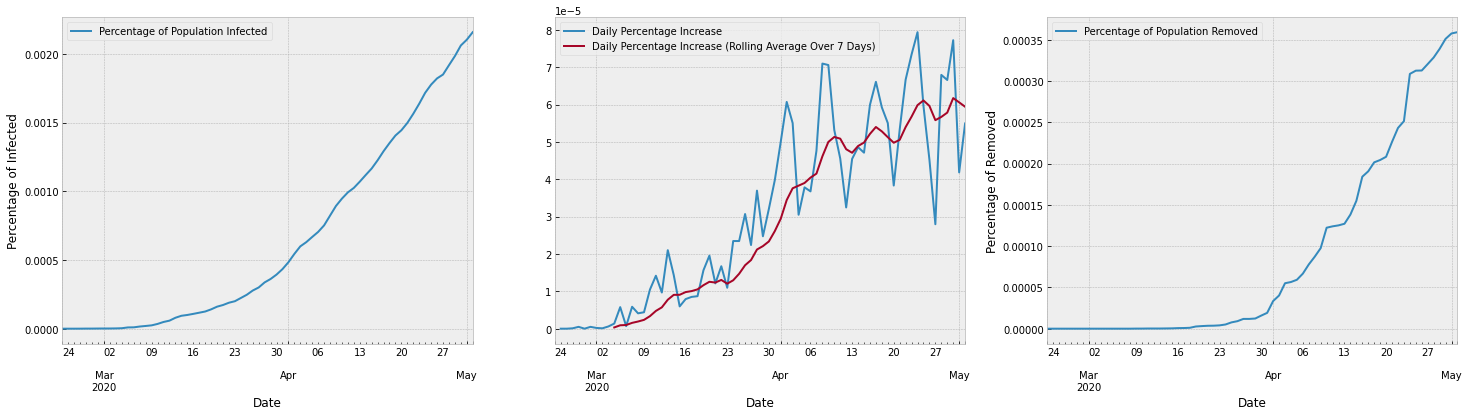

In [160]:
%matplotlib inline
plt.style.use('bmh')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,6))

infected.plot(ax=ax[0], label='Percentage of Population Infected', grid=True)
ax[0].set_ylabel('Percentage of Infected')

new_cases.plot(ax=ax[1], label='Daily Percentage Increase')
new_cases.rolling(window=10).mean().plot(ax=ax[1], 
                                        label='Daily Percentage Increase (Rolling Average Over 7 Days)', grid=True)

removed.plot(ax=ax[2], label='Percentage of Population Removed', grid=True)
ax[2].set_ylabel('Percentage of Removed')

for subax in ax:
  subax.set_xlabel('Date')
  subax.legend()

#SIR Model

In [0]:
# Saving these code segments for later use

sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0.25, 5, 0.25),
    n_states=2,
    n_theta=2,
    t0=0,
)

with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occured
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2,3)
    lam = pm.Lognormal('lambda',pm.math.log(2),2)
    beta = pm.Deterministic('beta', lam*R0)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, lam])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sd=sigma, observed=yobs)

  prior = pm.sample_prior_predictive()
  trace = pm.sample(1000,tune=500, target_accept=0.9, cores=1)
  posterior_predictive = pm.sample_posterior_predictive(trace)

  data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda, R0, sigma]
Sampling chain 0, 0 divergences:  92%|█████████▏| 1374/1500 [10:11<00:42,  2.98it/s]

In [0]:
def SIR(y, t, p):
    ds = -p[0]*y[0]*y[1]
    di = p[0]*y[0]*y[1] - p[1]*y[1]
    dr = p[1]*y[1]
    return [ds, di, dr]


sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0.25, 5, 0.25),
    n_states=3,
    n_theta=2,
    t0=0,
)

times = np.arange(0,5,0.25)

In [0]:
with pm.Model() as model:

  theta0I = pm.Beta('theta0I', 1, 10)
  theta0S = pm.Beta('theta0S', 1, 10)
  theta0R = 1 - theta0S - theta0I

  R0 = pm.Lognormal('R0', mu=3.15, sigma=1)
  gamma = pm.Lognormal('gamma', mu=0.0117, sigma=0.1)
  beta = pm.Deterministic('beta', gamma*R0)

  kappa = pm.Gamma('kappa', 2, 0.0001)

  f = sir_model(y0=[theta0S, theta0I, theta0R], theta=[beta, gamma])
  theta = pm.Dirichlet('theta', kappa*f, observed=[susceptible, infected, removed])

  #lambdaI = pm.Gamma('lambdaI', 2, 0.0001)
  #lambdaR = pm.Gamma('labmdaR', 2, 0.0001)

  #YI = pm.Beta('YI', alpha=lambdaI*theta[1], beta=lambdaI*(1 - theta[1]), observed=yobs[:,1])